In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import thymio_datas

## Import Thymio data

In [2]:
thymio_data=thymio_datas.dataPath2

In [3]:
# Remove data where camera didn't find thymio robot
thymio_data=[item for item in thymio_data if not(item["posex"]==-1 and item["posey"]==-1)]

In [4]:
convert_speed_to_mms=0.43478260869565216

h=69 # cm, camera height
ratio_pixel2mm=h/69 # converts pixels to mm based on camera height


x_cam=[ratio_pixel2mm*item["posex"] for item in thymio_data]
y_cam=[ratio_pixel2mm*item["posey"] for item in thymio_data]
alpha_cam=[item["alpha"] for item in thymio_data]
target_l=[convert_speed_to_mms*item["left_target"] for item in thymio_data]
target_r=[convert_speed_to_mms*item["right_target"] for item in thymio_data]
speed_l=[convert_speed_to_mms*item["left_speed"] for item in thymio_data]
speed_r=[convert_speed_to_mms*item["right_speed"] for item in thymio_data]
v_cam=[convert_speed_to_mms*(item["left_target"]+item["right_target"])/2 for item in thymio_data]

T=[item["dt"] for item in thymio_data]

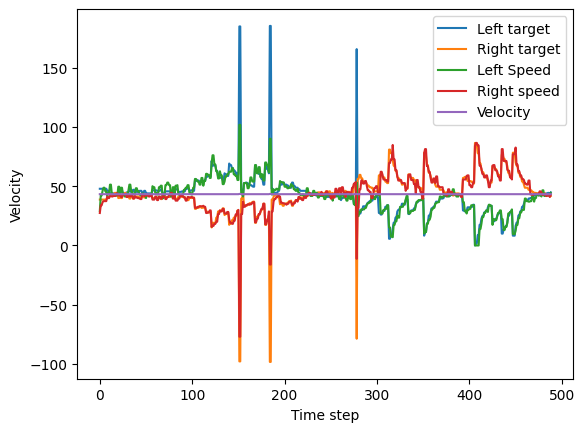

In [5]:
plt.plot(target_l, label="Left target")
plt.plot(target_r, label="Right target")
plt.plot(speed_l, label="Left Speed")
plt.plot(speed_r, label="Right speed")
plt.plot(v_cam, label="Velocity")
plt.xlabel("Time step")
plt.ylabel("Velocity")
plt.legend()

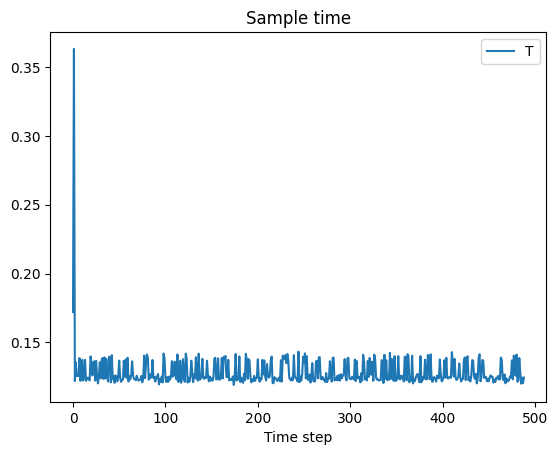

In [6]:
# Sample time 
plt.plot(T, label="T")
plt.xlabel("Time step")
plt.title('Sample time')
plt.legend()

## Prediction using model

In [7]:
d=95 # mm, distance between wheels

x_pred=np.array(x_cam.copy())
y_pred=np.array(y_cam.copy())
alpha_pred=np.array(alpha_cam.copy())
v_pred=np.array(v_cam.copy())


for k in range(len(thymio_data)-1):
    # Predicted states
    x_pred[k+1] = x_cam[k] + T[k] * v_pred[k] * np.cos(alpha_cam[k])
    y_pred[k+1] = y_cam[k] + T[k] * v_pred[k] * np.sin(alpha_cam[k])
    alpha_pred[k+1] = alpha_cam[k] + T[k]* (target_l[k] - target_r[k]) / d
    v_pred[k+1] = (target_r[k] + target_l[k]) / 2


#gives same sign to alpha_pred and alpha_cam
for i,pred in enumerate(alpha_pred):
    if np.sign(pred*alpha_cam[i])<0:
        alpha_pred[i]+=np.sign(alpha_cam[i])*2*np.pi


Text(0, 0.5, 'Camera - Prediction (mm/s)')

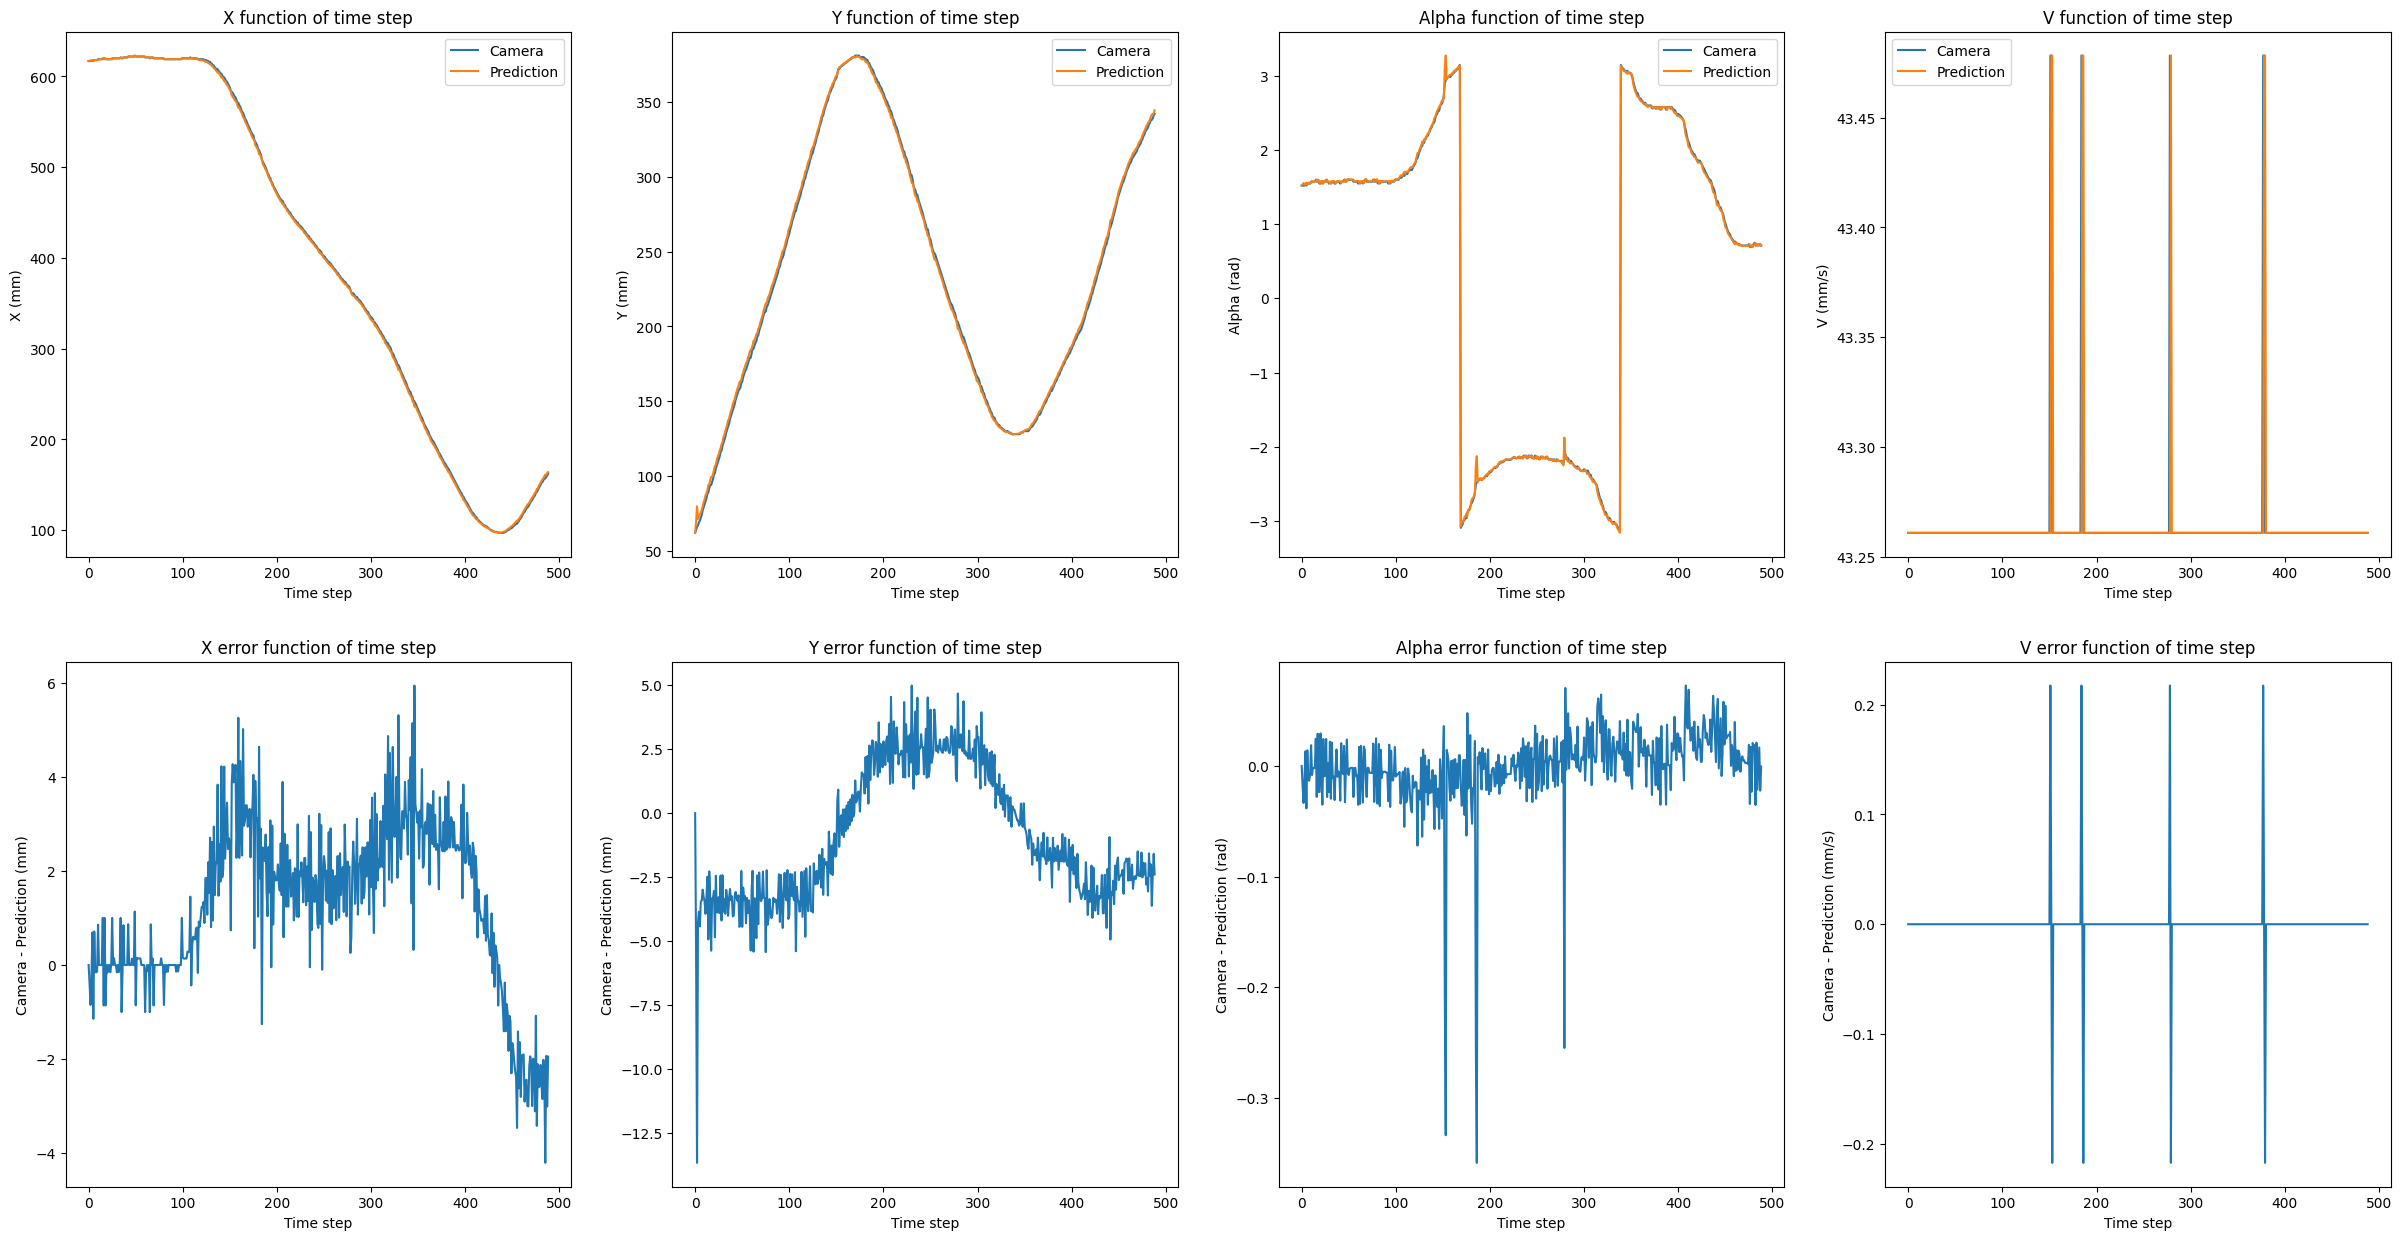

In [8]:
fig, axs = plt.subplots(2,4,figsize=(30,15))
axs[0,0].plot(x_cam, label='Camera')
axs[0,0].plot(x_pred, label='Prediction')
axs[0,0].set_title('X function of time step')
axs[0,0].set_xlabel('Time step')
axs[0,0].set_ylabel('X (mm)')
axs[0,0].legend()
axs[0,1].plot(y_cam, label='Camera')
axs[0,1].plot(y_pred, label='Prediction')
axs[0,1].set_title('Y function of time step')
axs[0,1].set_xlabel('Time step')
axs[0,1].set_ylabel('Y (mm)')
axs[0,1].legend()
axs[0,2].plot(alpha_cam, label='Camera')
axs[0,2].plot(alpha_pred, label='Prediction')
axs[0,2].set_title('Alpha function of time step')
axs[0,2].set_xlabel('Time step')
axs[0,2].set_ylabel('Alpha (rad)')
axs[0,2].legend()
axs[0,3].plot(v_cam, label='Camera')
axs[0,3].plot(v_pred, label='Prediction')
axs[0,3].set_title('V function of time step')
axs[0,3].set_xlabel('Time step')
axs[0,3].set_ylabel('V (mm/s)')
axs[0,3].legend()

axs[1,0].plot(x_cam-x_pred)
axs[1,0].set_title('X error function of time step')
axs[1,0].set_xlabel('Time step')
axs[1,0].set_ylabel('Camera - Prediction (mm)')
axs[1,1].plot(y_cam-y_pred)
axs[1,1].set_title('Y error function of time step')
axs[1,1].set_xlabel('Time step')
axs[1,1].set_ylabel('Camera - Prediction (mm)')
axs[1,2].plot(alpha_cam-alpha_pred)
axs[1,2].set_title('Alpha error function of time step')
axs[1,2].set_xlabel('Time step')
axs[1,2].set_ylabel('Camera - Prediction (rad)')
axs[1,3].plot(v_cam-v_pred)
axs[1,3].set_title('V error function of time step')
axs[1,3].set_xlabel('Time step')
axs[1,3].set_ylabel('Camera - Prediction (mm/s)')


## Model variances determination

In [9]:
# Q matrix determination Q=np.diag([err_x_std, err_y_std, err_alpha_std, err_v_std])
model_err_x_std=np.std(x_pred-x_cam)
model_err_y_std=np.std(y_pred-y_cam)
model_err_alpha_std=np.std(alpha_pred-alpha_cam)
model_err_v_std=np.std(v_pred-v_cam)

print('x std :',model_err_x_std)
print('y std :',model_err_y_std)
print('alpha std :',model_err_alpha_std)
print('v std :',model_err_v_std)

x std : 1.753999636569676
y std : 2.5832717319349294
alpha std : 0.03738207502328924
v std : 0.027805629538742476


## Sensor variances determination

In [10]:
avg_target=np.array([(l+r)/2 for l,r in zip(target_l,target_r)])
avg_speed=np.array([(l+r)/2 for l,r in zip(speed_l,speed_r)])

In [11]:
# R matrix determination

thymio_data=thymio_datas.dataPose1

x_cam1=np.array([ratio_pixel2mm*item["posex"] for item in thymio_data])
y_cam1=np.array([ratio_pixel2mm*item["posey"] for item in thymio_data])
alpha_cam1=np.array([item["alpha"] for item in thymio_data])

thymio_data=thymio_datas.dataPose2

x_cam2=np.array([ratio_pixel2mm*item["posex"] for item in thymio_data])
y_cam2=np.array([ratio_pixel2mm*item["posey"] for item in thymio_data])
alpha_cam2=np.array([item["alpha"] for item in thymio_data])

########################### Merge two variances ##############################

sensor_err_x_std=np.sqrt((len(x_cam1)*np.var(x_cam1)+len(x_cam2)*np.var(x_cam2))/(len(x_cam1)+len(x_cam2)))
sensor_err_y_std=np.sqrt((len(y_cam1)*np.var(y_cam1)+len(y_cam2)*np.var(y_cam2))/(len(y_cam1)+len(y_cam2)))
sensor_err_alpha_std=np.sqrt((len(alpha_cam1)*np.var(alpha_cam1)+len(alpha_cam2)*np.var(alpha_cam2))/(len(alpha_cam1)+len(alpha_cam2)))

sensor_err_v_std=np.std(avg_speed-avg_target)

print('sensor x std :',sensor_err_x_std)
print('sensor y std :',sensor_err_y_std)
print('sensor alpha std :',sensor_err_alpha_std)
print('sensor v std :', sensor_err_v_std)

sensor x std : 0.20344381248915722
sensor y std : 0.7420408115479226
sensor alpha std : 0.010427969435971924
sensor v std : 3.127273511234235


Text(0, 0.5, 'Speed measurement - Target (mm/s)')

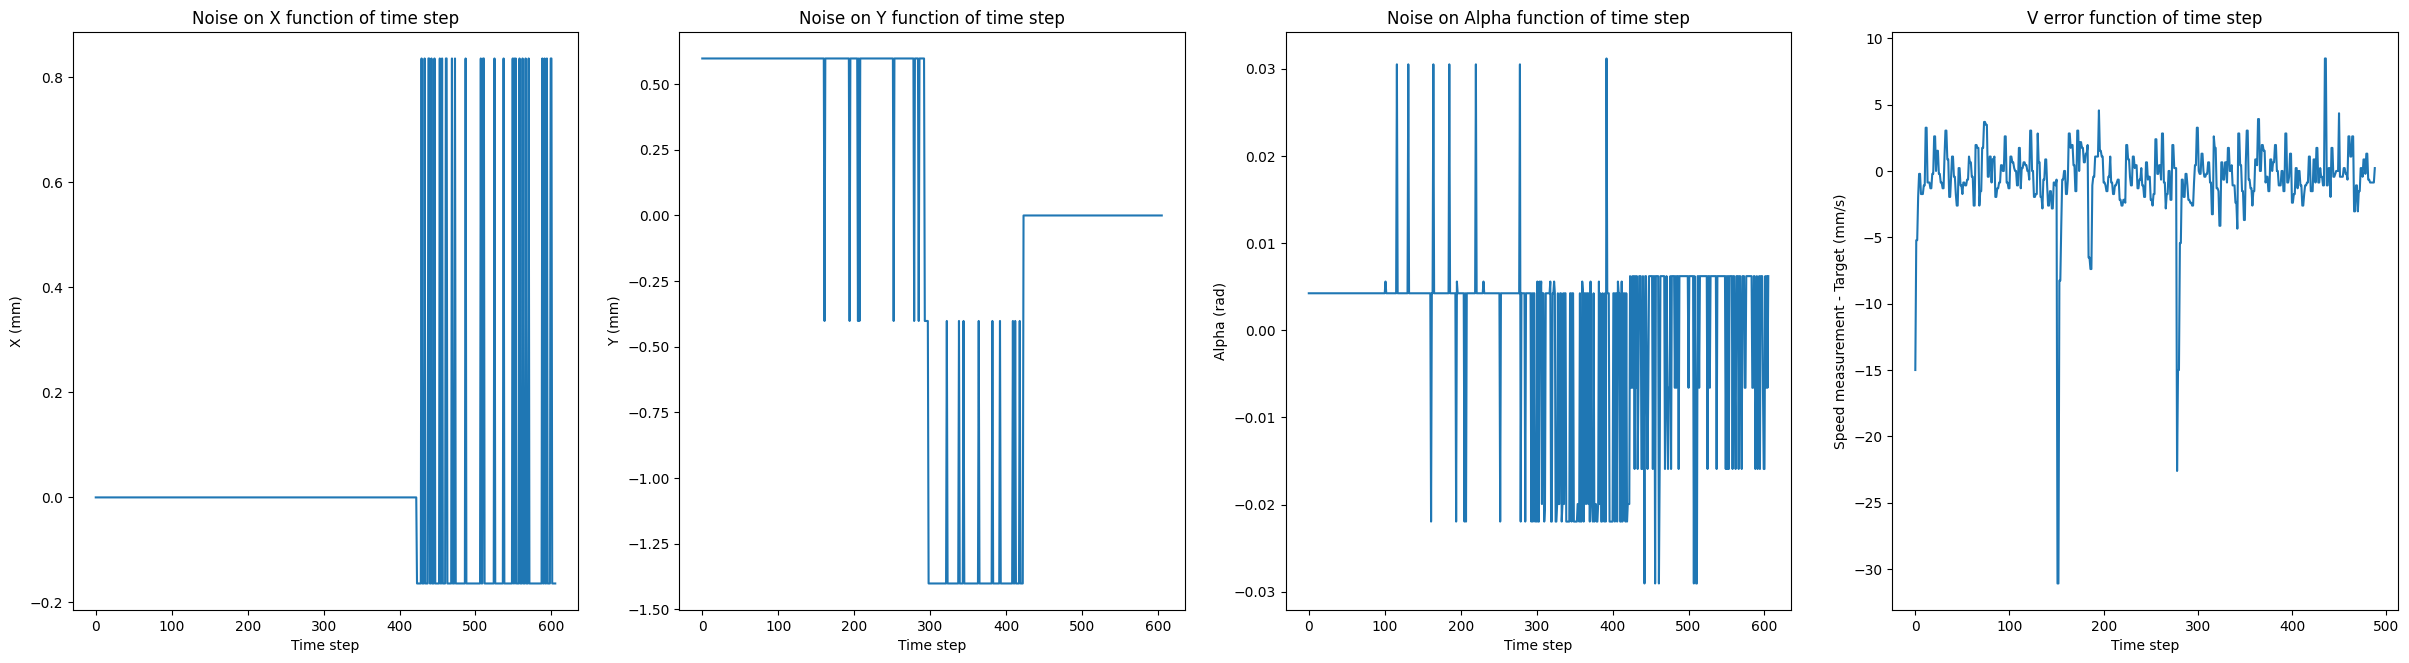

In [12]:
fig, axs = plt.subplots(1,4,figsize=(30,7.5))

axs[0].plot(list(x_cam1-x_cam1.mean())+list(x_cam2-x_cam2.mean()))
axs[0].set_title('Noise on X function of time step')
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('X (mm)')
axs[1].plot(list(y_cam1-y_cam1.mean())+list(y_cam2-y_cam2.mean()))
axs[1].set_title('Noise on Y function of time step')
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Y (mm)')
axs[2].plot(list(alpha_cam1-alpha_cam1.mean())+list(alpha_cam2-alpha_cam2.mean()))
axs[2].set_title('Noise on Alpha function of time step')
axs[2].set_xlabel('Time step')
axs[2].set_ylabel('Alpha (rad)')
axs[3].plot(avg_speed-avg_target)
axs[3].set_title('V error function of time step')
axs[3].set_xlabel('Time step')
axs[3].set_ylabel('Speed measurement - Target (mm/s)')

## Q and R matrices

In [13]:
Q=np.diag([model_err_x_std, model_err_y_std, model_err_alpha_std, model_err_v_std])
R=np.diag([sensor_err_x_std, sensor_err_y_std, sensor_err_alpha_std, sensor_err_v_std])

print("Q :",Q)
print("\nR :",R)

Q : [[1.75399964 0.         0.         0.        ]
 [0.         2.58327173 0.         0.        ]
 [0.         0.         0.03738208 0.        ]
 [0.         0.         0.         0.02780563]]

R : [[0.20344381 0.         0.         0.        ]
 [0.         0.74204081 0.         0.        ]
 [0.         0.         0.01042797 0.        ]
 [0.         0.         0.         3.12727351]]
